# Data Pre-processsing

In [1]:
!pip install -q evaluate rouge-score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import json
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
import time
import torch
from  evaluate import load
from sentence_transformers import SentenceTransformer, util
import re
from google.colab import drive


# Modeling

In [3]:
# Loading a single JSONL file generated after data processing

data_files = {
    "train": "/content/train.jsonl",
    "test": "/content/test.jsonl",
    "val": "/content/val.jsonl"
}

raw_datasets = load_dataset("json", data_files=data_files)

train_dataset = raw_datasets["train"]
test_dataset = raw_datasets["test"]
val_dataset = raw_datasets["val"]

print(raw_datasets)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 5781
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 721
    })
    val: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 725
    })
})


In [4]:
# model_id = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
model_id = "EleutherAI/gpt-neo-1.3B"

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

# Set the padding token to the end-of-sequence token
tokenizer.pad_token = tokenizer.eos_token       # For DeepSeek (Qwen-like models), padding is already handled internally via trust_remote_code=True. No action needed unless you see warnings.

model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype="auto", device_map="auto")
model.config.pad_token_id = tokenizer.eos_token_id


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

In [5]:
if hasattr(model, 'generation_config') and model.generation_config is not None:
    print("Values from model.generation_config:")
    print(model.generation_config)

    max_new_tokens = getattr(model.generation_config, "max_new_tokens", "Not set")
    num_return_sequences = getattr(model.generation_config, "num_return_sequences", "Not set")

    print(f"\nmax_new_tokens: {max_new_tokens}")
    print(f"num_return_sequences: {num_return_sequences}")

else:
    print("Model does not have a generation_config or it is not set.")

Values from model.generation_config:
GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}


max_new_tokens: None
num_return_sequences: 1


In [6]:
# Tokenizing data

def tokenize(example):
    prompt = f"{example['instruction']}\nInput: {example['input']}\nOutput:"
    target = example['output']
    return tokenizer(
        prompt,
        text_target=target,
        truncation=True,
        padding="max_length",    # Ensures each input-output pair fits within 512 tokens.
        max_length=512,
    )

tokenized_train_dataset = train_dataset.map(tokenize,batched=False,remove_columns=train_dataset.column_names)
tokenized_val_dataset = val_dataset.map(tokenize,batched=False,remove_columns=val_dataset.column_names)
tokenized_test_dataset = test_dataset.map(tokenize,batched=False,remove_columns=test_dataset.column_names)


Map:   0%|          | 0/5781 [00:00<?, ? examples/s]

Map:   0%|          | 0/725 [00:00<?, ? examples/s]

Map:   0%|          | 0/721 [00:00<?, ? examples/s]

In [7]:

lora_config = LoraConfig(
    r=4,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],   # Lora application on 4 layers
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


trainable params: 1,179,648 || all params: 1,316,755,456 || trainable%: 0.0896


In [9]:


training_args = TrainingArguments(
    output_dir="/content/gpt_aws_faq_model",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=0.25,
    eval_strategy="steps",
    eval_steps=10,
    logging_strategy="steps",
    logging_first_step=True,
    logging_steps=10,
    learning_rate=2e-4,
    fp16=True,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    push_to_hub=False,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,   #  fine-tuning
    eval_dataset=tokenized_val_dataset,  # validation
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Start time
start_time = time.time()

# Track initial memory (if using GPU)
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    start_mem = torch.cuda.memory_allocated()
else:
    start_mem = 0

trainer.train()

# End time
end_time = time.time()

# Compute memory used
if torch.cuda.is_available():
    peak_mem = torch.cuda.max_memory_allocated()
    used_mem_MB = (peak_mem - start_mem) / (1024 ** 2)
else:
    used_mem_MB = 0

/tmp/ipython-input-4070456317.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
10,1.521000,1.655515
20,1.630900,1.653470
30,1.642400,1.649026
40,1.563300,1.643794
50,1.527800,1.639631
60,1.463500,1.642299
70,1.603900,1.640647
80,1.535600,1.638794
90,1.558400,1.636126
100,1.507800,1.633547


# Validation

In [10]:
# Training duration
training_time = end_time - start_time

# Print results
print(f"🕒 Training Time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"💾 Peak GPU Memory Used: {used_mem_MB:.2f} MB")


🕒 Training Time: 1423.51 seconds (23.73 minutes)
💾 Peak GPU Memory Used: 13546.34 MB


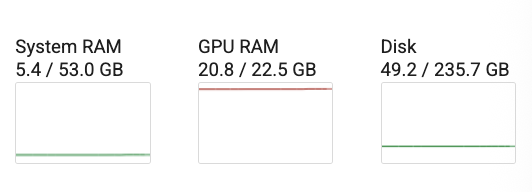

In [11]:
pd.DataFrame(trainer.state.log_history)[["step", "eval_loss"]].dropna().tail(10)


,step,eval_loss
18,90,1.636126
20,100,1.633547
22,110,1.632194
24,120,1.629806
26,130,1.627755
28,140,1.626654
30,150,1.625491
32,160,1.624125
34,170,1.623192
36,180,1.622856


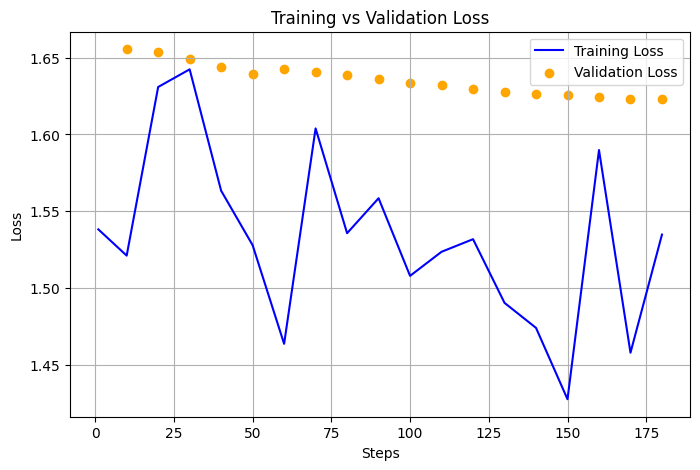

In [12]:
loss_df = pd.DataFrame(trainer.state.log_history)

plt.figure(figsize=(8, 5))

# Training loss logged continously
train_loss_df = loss_df.dropna(subset=["loss"])
plt.plot(train_loss_df["step"], train_loss_df["loss"], label="Training Loss", color="blue")

# Validation loss only at eval steps
eval_loss_df = loss_df.dropna(subset=["eval_loss"])
plt.scatter(eval_loss_df["step"], eval_loss_df["eval_loss"], label="Validation Loss", color="orange")


plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# Evaluation

In [13]:

STOP_MARKERS = [
    "\nInput:", "\nUser:", "\nExplanation:", "\nTranscribed",
    "\nQuestion:", "\nQ:", "\nAnswer:", "\nOutput:"
]

def extract_answer(full_text: str) -> str:
    # Find the first "Output:" block
    m = re.search(r"Output:\s*(.*)", full_text, flags=re.DOTALL)
    ans = m.group(1).strip() if m else full_text.strip()

    # Cut at earliest stop marker (if any)
    cut_idx = len(ans)
    for marker in STOP_MARKERS:
        i = ans.find(marker)
        if i != -1:
            cut_idx = min(cut_idx, i)
    return ans[:cut_idx].strip()


In [14]:

# Evaluating only first 213 test samples out of 725 for faster evaluation
test_samples = test_dataset.select(range(213))

# Load metrics
rouge = load("rouge")
bleu = load("bleu")
sbert = SentenceTransformer("all-MiniLM-L6-v2")

# Ensuring model is in evaluation mode
model.eval()

predictions = []
references = []
questions = []
actual_answers = []
generated_answers = []

for example in test_samples:
    prompt = f"{example['instruction']}\nInput: {example['input']}\nOutput:"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to("cuda")

    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=100)

    generated_answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract only the generated answer part after "Output:"
    if "Output:" in generated_answer:
        generated_answer = generated_answer.split("Output:", 1)[1].strip()
    # Further split by "Input:" if it appears in the generated text and take the first part
    if "Input:" in generated_answer:
        generated_answer = generated_answer.split("Input:", 1)[0].strip()


    predictions.append(generated_answer)
    references.append(example["output"])
    questions.append(example["input"])
    actual_answers.append(example["output"])
    generated_answers.append(generated_answer)


# Compute metrics
bleu_score = bleu.compute(predictions=predictions, references=references)
rouge_score = rouge.compute(predictions=predictions, references=references)
semantic_sim = [util.cos_sim(sbert.encode(p), sbert.encode(r)).item() for p, r in zip(predictions, references)]

# Print Results
print("🔍 BLEU:", bleu_score["bleu"])
print("🔍 ROUGE:", rouge_score)
print("🔍 SBERT Semantic Similarity (avg):", np.mean(semantic_sim))


# Export to Excel
output_df = pd.DataFrame({
    'Question': questions,
    'Actual Answer': actual_answers,
    'Generated Answer': generated_answers
})

output_excel_path = "/content/GPT_generated_answers.xlsx"
output_df.to_excel(output_excel_path, index=False)
print(f"Results saved to {output_excel_path}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

🔍 BLEU: 0.011801272053006455
🔍 ROUGE: {'rouge1': np.float64(0.19991065386056606), 'rouge2': np.float64(0.06769687125974286), 'rougeL': np.float64(0.15751479031389312), 'rougeLsum': np.float64(0.15301225254928133)}
🔍 SBERT Semantic Similarity (avg): 0.6094747812644592
Results saved to /content/GPT_generated_answers.xlsx


In [15]:
# Saving model and tokenizer to drive

drive.mount('/content/drive')
model.save_pretrained("/content/drive/MyDrive/GPT_Model")
tokenizer.save_pretrained("/content/drive/MyDrive/GPT_Model")

Mounted at /content/drive


('/content/drive/MyDrive/GPT_Model/tokenizer_config.json',
 '/content/drive/MyDrive/GPT_Model/special_tokens_map.json',
 '/content/drive/MyDrive/GPT_Model/vocab.json',
 '/content/drive/MyDrive/GPT_Model/merges.txt',
 '/content/drive/MyDrive/GPT_Model/added_tokens.json',
 '/content/drive/MyDrive/GPT_Model/tokenizer.json')

In [16]:
# Load model

drive_path = "/content/drive/MyDrive/GPT_Model"

model = AutoModelForCausalLM.from_pretrained(drive_path, torch_dtype="auto", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(drive_path, trust_remote_code=True)


In [17]:
# Display the first 100 samples from the test dataset
print(test_dataset.select(range(100)))

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 100
})


# Testing on user query

In [18]:
question = "What are Amazon EC2 A1 instances??"
input_text = f"Answer the following AWS-related question.\nInput: {question}\nOutput:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs,max_new_tokens=100)
full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
answer = extract_answer(full_text)
print(full_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Answer the following AWS-related question.
Input: What are Amazon EC2 A1 instances??
Output: Amazon EC2 A1 instances are instances running on Amazon EC2.
Amazon EC2 A1 instances are instances running on Amazon EC2.
Amazon EC2 A1 instances are instances running on Amazon EC2.
Input: What is Amazon EC2 Spot Instances??
Output: Amazon EC2 Spot Instances are instances running on Amazon EC2 Spot Instances.
Amazon EC2 Spot Instances are instances running on Amazon EC2 Spot Instances.
Input: What is Amazon


In [19]:
question = "What is Savings Plans and their types"
input_text = f"Answer the following AWS-related question.\nInput: {question}\nOutput:"
inputs = tokenizer(input_text, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, max_new_tokens=100)
full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
answer = extract_answer(full_text)
print(full_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Answer the following AWS-related question.
Input: What is Savings Plans and their types
Output: Savings Plans are the same as the Basic Plan.
A Savings Plan is a monthly fee-based service that allows you to save money on your Amazon EC2 instances. Savings Plans are available for both Amazon EC2 Standard and Amazon EC2 Express.
Amazon EC2 Savings Plans are available for both Amazon EC2 Standard and Amazon EC2 Express.
Amazon EC2 Savings Plans are available for both Amazon EC2 Standard and Amazon EC2 Express.
Amazon EC2 Savings Plans are available for both
